In [1]:
!nvidia-smi

Fri Mar  1 00:16:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   39C    P8              20W / 215W |    473MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
data_dir = '../data/data_preprocessed/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [8]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [9]:
labels = ['ang', 'neu', 'sad', 'hap']
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [10]:
import traceback
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13mfcc.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 40, 'n_fft': 512, 'hop_length': 128, 'n_mels': 64, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [11]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [12]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [13]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                               | 0.001142857142857143/10 [00:00<1:09:40, 418.08s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.612252
Mem before-during-after: 1226752 9887232 21712384


  0%|                                 | 0.023999999999999983/10 [00:07<49:53, 300.05s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.195113
Mem before-during-after: 21712384 21852160 21712384


  0%|▏                                | 0.046857142857142785/10 [00:13<42:41, 257.40s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.214742
Mem before-during-after: 21712384 21852160 21712384


  1%|▏                                 | 0.06971428571428559/10 [00:19<46:20, 280.04s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 0.988580
Mem before-during-after: 21712384 21852160 21712384


  1%|▎                                 | 0.09257142857142839/10 [00:26<46:06, 279.20s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.000542
Mem before-during-after: 21712384 21852160 21712384


  1%|▍                                 | 0.11542857142857119/10 [00:32<42:06, 255.60s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 0.916069
Mem before-during-after: 21712384 21852160 21712384


  1%|▍                                 | 0.13828571428571432/10 [00:38<42:12, 256.77s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.448993
Mem before-during-after: 21712384 21852160 21712384


  2%|▌                                 | 0.16114285714285767/10 [00:44<42:14, 257.60s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 1.099703
Mem before-during-after: 21712384 21852160 21712384


  2%|▋                                 | 0.18400000000000102/10 [00:50<41:41, 254.79s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 1.034515
Mem before-during-after: 21712384 21852160 21712384


  2%|▋                                 | 0.20685714285714438/10 [00:56<42:51, 262.58s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 1.061158
Mem before-during-after: 21712384 21852160 21712384


  2%|▊                                 | 0.22971428571428773/10 [01:02<43:04, 264.50s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.087759
Mem before-during-after: 21712384 21852160 21712384


  3%|▊                                 | 0.25257142857143094/10 [01:08<41:18, 254.28s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 0.893102
Mem before-during-after: 21712384 21852160 21712384


  3%|▉                                  | 0.2754285714285732/10 [01:14<41:01, 253.09s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 1.006628
Mem before-during-after: 21712384 21852160 21712384


  3%|█                                 | 0.29828571428571543/10 [01:20<52:38, 325.52s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 0.917931
Mem before-during-after: 21712384 21852160 21712384


  3%|█                                  | 0.3211428571428577/10 [01:26<42:29, 263.39s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 0.963505
Mem before-during-after: 21712384 21852160 21712384


  3%|█▏                                 | 0.3439999999999999/10 [01:32<41:38, 258.75s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 0.699052
Mem before-during-after: 21712384 21852160 21712384


  4%|█▏                                | 0.36685714285714216/10 [01:38<41:08, 256.22s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 1.274884
Mem before-during-after: 21712384 21852160 21712384


  4%|█▎                                 | 0.3897142857142844/10 [01:44<41:46, 260.83s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 0.946303
Mem before-during-after: 21712384 21852160 21712384


  4%|█▍                                | 0.41257142857142665/10 [01:50<41:36, 260.40s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 1.061240
Mem before-during-after: 21712384 21852160 21712384


  4%|█▌                                 | 0.4354285714285689/10 [01:56<40:50, 256.19s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 0.981416
Mem before-during-after: 21712384 21852160 21712384


  5%|█▌                                | 0.45828571428571113/10 [02:02<41:51, 263.22s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 0.888597
Mem before-during-after: 21712384 21852160 21712384


  5%|█▋                                 | 0.4811428571428534/10 [02:08<40:53, 257.78s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 0.633108
Mem before-during-after: 21712384 21852160 21712384


  5%|█▊                                 | 0.5039999999999957/10 [02:14<41:00, 259.14s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 0.938819
Mem before-during-after: 21712384 21852160 21712384


  5%|█▊                                 | 0.5268571428571379/10 [02:20<40:41, 257.69s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 0.632103
Mem before-during-after: 21712384 21852160 21712384


  5%|█▉                                 | 0.5497142857142802/10 [02:26<40:26, 256.76s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 0.926161
Mem before-during-after: 21712384 21852160 21712384


  6%|██                                 | 0.5725714285714224/10 [02:32<40:23, 257.05s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 0.872949
Mem before-during-after: 21712384 21852160 21712384


  6%|██                                 | 0.5954285714285646/10 [02:38<43:15, 275.95s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 0.904938
Mem before-during-after: 21712384 21852160 21712384


  6%|██▏                                | 0.6182857142857069/10 [02:44<40:57, 262.00s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 1.152213
Mem before-during-after: 21712384 21852160 21712384


  6%|██▏                                | 0.6411428571428491/10 [02:50<41:57, 269.04s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 0.771055
Mem before-during-after: 21712384 21852160 21712384


  7%|██▎                                | 0.6639999999999914/10 [02:56<39:38, 254.81s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 0.865183
Mem before-during-after: 21712384 21852160 21712384


  7%|██▍                                | 0.6868571428571336/10 [03:02<40:20, 259.87s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 0.752592
Mem before-during-after: 21712384 21852160 21712384


  7%|██▍                                | 0.7097142857142759/10 [03:08<40:45, 263.21s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 0.598364
Mem before-during-after: 21712384 21852160 21712384


  7%|██▌                                | 0.7325714285714181/10 [03:14<40:30, 262.25s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 0.685207
Mem before-during-after: 21712384 21852160 21712384


  8%|██▋                                | 0.7554285714285603/10 [03:20<38:37, 250.71s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 1.045972
Mem before-during-after: 21712384 21852160 21712384


  8%|██▋                                | 0.7782857142857026/10 [03:26<40:03, 260.61s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 0.540190
Mem before-during-after: 21712384 21852160 21712384


 10%|███▌                                | 1.000571428571411/10 [04:23<38:39, 257.70s/it]


Test Epoch: 1	Accuracy: 3704/5600 (66%)

Train Epoch: 2 [0/22400 (0%)]	Loss: 0.925355
Mem before-during-after: 21711360 21852160 21712384


 10%|███▌                               | 1.0239999999999863/10 [04:29<38:15, 255.71s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 0.427662
Mem before-during-after: 21712384 21852160 21712384


 10%|███▊                                | 1.046857142857133/10 [04:35<38:46, 259.90s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 0.876295
Mem before-during-after: 21712384 21852160 21712384


 11%|███▋                               | 1.0697142857142796/10 [04:41<39:15, 263.80s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 0.608846
Mem before-during-after: 21712384 21852160 21712384


 11%|███▊                               | 1.0925714285714263/10 [04:47<38:03, 256.39s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 0.466772
Mem before-during-after: 21712384 21852160 21712384


 11%|████                                | 1.115428571428573/10 [04:53<39:29, 266.70s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 0.411165
Mem before-during-after: 21712384 21852160 21712384


 11%|███▉                               | 1.1382857142857197/10 [04:59<39:15, 265.82s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 0.343059
Mem before-during-after: 21712384 21852160 21712384


 12%|████                               | 1.1611428571428664/10 [05:05<37:42, 255.95s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 0.562275
Mem before-during-after: 21712384 21852160 21712384


 12%|████▎                               | 1.184000000000013/10 [05:11<39:27, 268.51s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 0.374167
Mem before-during-after: 21712384 21852160 21712384


 12%|████▏                              | 1.2068571428571597/10 [05:17<36:44, 250.73s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 0.517539
Mem before-during-after: 21712384 21852160 21712384


 12%|████▎                              | 1.2297142857143064/10 [05:23<37:53, 259.19s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 0.641664
Mem before-during-after: 21712384 21852160 21712384


 13%|████▌                               | 1.252571428571453/10 [05:29<37:29, 257.18s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 0.727917
Mem before-during-after: 21712384 21852160 21712384


 13%|████▍                              | 1.2754285714285998/10 [05:35<37:43, 259.41s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 0.512271
Mem before-during-after: 21712384 21852160 21712384


 13%|████▌                              | 1.2982857142857465/10 [05:41<37:11, 256.50s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 0.590123
Mem before-during-after: 21712384 21852160 21712384


 13%|████▌                              | 1.3211428571428931/10 [05:47<37:52, 261.83s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 0.792786
Mem before-during-after: 21712384 21852160 21712384


 13%|████▋                              | 1.3440000000000398/10 [05:53<36:52, 255.61s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 0.411521
Mem before-during-after: 21712384 21852160 21712384


 14%|████▊                              | 1.3668571428571865/10 [05:59<36:49, 255.95s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 1.345430
Mem before-during-after: 21712384 21852160 21712384


 14%|████▊                              | 1.3897142857143332/10 [06:05<36:50, 256.76s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 0.665081
Mem before-during-after: 21712384 21852160 21712384


 14%|████▉                              | 1.4125714285714799/10 [06:11<36:47, 257.11s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 0.652102
Mem before-during-after: 21712384 21852160 21712384


 14%|█████                              | 1.4354285714286266/10 [06:17<36:55, 258.71s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 0.693536
Mem before-during-after: 21712384 21852160 21712384


 15%|█████                              | 1.4582857142857732/10 [06:23<36:30, 256.40s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 0.807337
Mem before-during-after: 21712384 21852160 21712384


 15%|█████▍                               | 1.48114285714292/10 [06:29<38:16, 269.56s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 0.616416
Mem before-during-after: 21712384 21852160 21712384


 15%|█████▎                             | 1.5040000000000666/10 [06:35<36:11, 255.63s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 0.643071
Mem before-during-after: 21712384 21852160 21712384


 15%|█████▎                             | 1.5268571428572133/10 [06:41<37:12, 263.53s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 0.964872
Mem before-during-after: 21712384 21852160 21712384


 15%|█████▋                               | 1.54971428571436/10 [06:46<35:20, 250.99s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 0.756967
Mem before-during-after: 21712384 21852160 21712384


 16%|█████▌                             | 1.5725714285715067/10 [06:52<36:01, 256.47s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 0.556478
Mem before-during-after: 21712384 21852160 21712384


 16%|█████▌                             | 1.5954285714286534/10 [06:58<36:16, 259.01s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 0.957255
Mem before-during-after: 21712384 21852160 21712384


 16%|██████▏                               | 1.6182857142858/10 [07:04<36:18, 259.95s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 0.914459
Mem before-during-after: 21712384 21852160 21712384


 16%|█████▋                             | 1.6411428571429467/10 [07:10<34:49, 250.01s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 0.564504
Mem before-during-after: 21712384 21852160 21712384


 17%|█████▊                             | 1.6640000000000934/10 [07:16<36:15, 260.99s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 0.751601
Mem before-during-after: 21712384 21852160 21712384


 17%|██████▏                              | 1.68685714285724/10 [07:22<36:13, 261.46s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 0.622865
Mem before-during-after: 21712384 21852160 21712384


 17%|█████▉                             | 1.7097142857143868/10 [07:28<35:46, 258.91s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 0.186885
Mem before-during-after: 21712384 21852160 21712384


 17%|██████                             | 1.7325714285715335/10 [07:34<36:49, 267.31s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 0.497463
Mem before-during-after: 21712384 21852160 21712384


 18%|██████▏                            | 1.7554285714286801/10 [07:40<35:16, 256.67s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 0.812850
Mem before-during-after: 21712384 21852160 21712384


 18%|██████▏                            | 1.7782857142858268/10 [07:47<35:24, 258.38s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 0.588667
Mem before-during-after: 21712384 21852160 21712384


 20%|███████                            | 2.0000000000001497/10 [08:44<37:58, 284.81s/it]


Test Epoch: 2	Accuracy: 4431/5600 (79%)



 20%|███████                            | 2.0011428571430065/10 [08:44<39:35, 296.96s/it]

Train Epoch: 3 [0/22400 (0%)]	Loss: 0.424033
Mem before-during-after: 21711360 21852160 21712384


 20%|███████                            | 2.0240000000001444/10 [08:50<33:54, 255.14s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 0.361548
Mem before-during-after: 21712384 21852160 21712384


 20%|███████▎                            | 2.046857142857282/10 [08:56<33:54, 255.76s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 0.521972
Mem before-during-after: 21712384 21852160 21712384


 21%|███████▋                             | 2.06971428571442/10 [09:02<33:37, 254.36s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 0.351903
Mem before-during-after: 21712384 21852160 21712384


 21%|███████▎                           | 2.0925714285715578/10 [09:08<34:15, 259.98s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 0.264642
Mem before-during-after: 21712384 21852160 21712384


 21%|███████▍                           | 2.1154285714286956/10 [09:14<33:34, 255.44s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 0.893017
Mem before-during-after: 21712384 21852160 21712384


 21%|███████▍                           | 2.1382857142858334/10 [09:20<33:35, 256.35s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 0.450978
Mem before-during-after: 21712384 21852160 21712384


 22%|███████▊                            | 2.161142857142971/10 [09:26<33:49, 258.94s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 0.599215
Mem before-during-after: 21712384 21852160 21712384


 22%|███████▊                            | 2.184000000000109/10 [09:32<32:51, 252.27s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 0.771012
Mem before-during-after: 21712384 21852160 21712384


 22%|███████▋                           | 2.2068571428572468/10 [09:38<33:39, 259.12s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 0.334652
Mem before-during-after: 21712384 21852160 21712384


 22%|███████▊                           | 2.2297142857143846/10 [09:44<33:25, 258.09s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 0.111212
Mem before-during-after: 21712384 21852160 21712384


 23%|███████▉                           | 2.2525714285715224/10 [09:50<33:10, 256.88s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 0.567602
Mem before-during-after: 21712384 21852160 21712384


 23%|████████▍                            | 2.27542857142866/10 [09:56<33:25, 259.62s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 0.452672
Mem before-during-after: 21712384 21852160 21712384


 23%|████████▎                           | 2.298285714285798/10 [10:02<34:38, 269.92s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 0.413019
Mem before-during-after: 21712384 21852160 21712384


 23%|████████▎                           | 2.321142857142936/10 [10:08<33:19, 260.42s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 0.574072
Mem before-during-after: 21712384 21852160 21712384


 23%|████████▏                          | 2.3440000000000736/10 [10:14<31:47, 249.19s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 0.600620
Mem before-during-after: 21712384 21852160 21712384


 24%|████████▎                          | 2.3668571428572114/10 [10:20<32:59, 259.28s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 0.335162
Mem before-during-after: 21712384 21852160 21712384


 24%|████████▌                           | 2.389714285714349/10 [10:26<33:11, 261.63s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 1.214410
Mem before-during-after: 21712384 21852160 21712384


 24%|████████▋                           | 2.412571428571487/10 [10:32<32:22, 255.98s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 0.665922
Mem before-during-after: 21712384 21852160 21712384


 24%|████████▊                           | 2.435428571428625/10 [10:38<32:34, 258.32s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 0.743516
Mem before-during-after: 21712384 21852160 21712384


 25%|████████▌                          | 2.4582857142857626/10 [10:44<32:07, 255.60s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 0.285461
Mem before-during-after: 21712384 21852160 21712384


 25%|████████▋                          | 2.4811428571429004/10 [10:50<33:00, 263.37s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 1.067546
Mem before-during-after: 21712384 21852160 21712384


 25%|█████████                           | 2.504000000000038/10 [10:56<32:01, 256.37s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 0.555849
Mem before-during-after: 21712384 21852160 21712384


 25%|█████████                           | 2.526857142857176/10 [11:02<32:31, 261.20s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 0.250183
Mem before-during-after: 21712384 21852160 21712384


 25%|█████████▏                          | 2.549714285714314/10 [11:08<32:08, 258.89s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 0.752921
Mem before-during-after: 21712384 21852160 21712384


 26%|█████████                          | 2.5725714285714516/10 [11:14<31:25, 253.88s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 0.828979
Mem before-during-after: 21712384 21852160 21712384


 26%|█████████                          | 2.5954285714285894/10 [11:20<32:37, 264.43s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 0.237670
Mem before-during-after: 21712384 21852160 21712384


 26%|█████████▍                          | 2.618285714285727/10 [11:26<31:47, 258.47s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 1.128381
Mem before-during-after: 21712384 21852160 21712384


 26%|█████████▌                          | 2.641142857142865/10 [11:32<31:48, 259.33s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 0.409403
Mem before-during-after: 21712384 21852160 21712384


 27%|█████████▌                          | 2.664000000000003/10 [11:38<44:23, 363.07s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 0.705819
Mem before-during-after: 21712384 21852160 21712384


 27%|█████████▍                         | 2.6868571428571406/10 [11:44<31:29, 258.33s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 0.270204
Mem before-during-after: 21712384 21852160 21712384


 27%|█████████▍                         | 2.7097142857142784/10 [11:50<31:51, 262.26s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 0.292597
Mem before-during-after: 21712384 21852160 21712384


 27%|█████████▊                          | 2.732571428571416/10 [11:56<30:26, 251.31s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 0.228648
Mem before-during-after: 21712384 21852160 21712384


 28%|█████████▉                          | 2.755428571428554/10 [12:02<31:42, 262.59s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 0.435743
Mem before-during-after: 21712384 21852160 21712384


 28%|██████████                          | 2.778285714285692/10 [12:10<33:45, 280.44s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 0.174033
Mem before-during-after: 21712384 21852160 21712384


 30%|██████████▊                         | 3.000571428571357/10 [13:07<29:56, 256.61s/it]


Test Epoch: 3	Accuracy: 4654/5600 (83%)

Train Epoch: 4 [0/22400 (0%)]	Loss: 0.220044
Mem before-during-after: 21711360 21852160 21712384


 30%|██████████▉                         | 3.023999999999923/10 [13:14<30:26, 261.80s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 0.818610
Mem before-during-after: 21712384 21852160 21712384


 30%|██████████▉                         | 3.046857142857061/10 [13:20<29:20, 253.17s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 0.494422
Mem before-during-after: 21712384 21852160 21712384


 31%|███████████                         | 3.069714285714199/10 [13:26<29:32, 255.79s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 0.936262
Mem before-during-after: 21712384 21852160 21712384


 31%|██████████▊                        | 3.0925714285713366/10 [13:31<29:10, 253.44s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 0.211893
Mem before-during-after: 21712384 21852160 21712384


 31%|██████████▉                        | 3.1154285714284744/10 [13:38<30:34, 266.44s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 0.362754
Mem before-during-after: 21712384 21852160 21712384


 31%|███████████▎                        | 3.138285714285612/10 [13:44<29:05, 254.31s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 0.339995
Mem before-during-after: 21712384 21852160 21712384


 32%|███████████▋                         | 3.16114285714275/10 [13:50<30:28, 267.32s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 0.443506
Mem before-during-after: 21712384 21852160 21712384


 32%|███████████▍                        | 3.183999999999888/10 [13:55<29:34, 260.37s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 0.957115
Mem before-during-after: 21712384 21852160 21712384


 32%|███████████▏                       | 3.2068571428570256/10 [14:01<29:30, 260.61s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 0.324627
Mem before-during-after: 21712384 21852160 21712384


 32%|███████████▎                       | 3.2297142857141634/10 [14:07<29:17, 259.60s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 0.646146
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████▋                        | 3.252571428571301/10 [14:13<30:47, 273.77s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 0.729838
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████▊                        | 3.275428571428439/10 [14:19<28:26, 253.76s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 0.301547
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████▊                        | 3.298285714285577/10 [14:25<27:59, 250.56s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 0.431664
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████▌                       | 3.3211428571427146/10 [14:31<28:26, 255.56s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 0.257060
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████▋                       | 3.3439999999998524/10 [14:37<28:01, 252.70s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 0.648163
Mem before-during-after: 21712384 21852160 21712384


 34%|███████████▊                       | 3.3668571428569902/10 [14:43<28:56, 261.74s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 0.127837
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████▏                       | 3.389714285714128/10 [14:49<28:46, 261.12s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 0.378269
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████▎                       | 3.412571428571266/10 [14:56<28:22, 258.39s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 0.075542
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████                       | 3.4354285714284036/10 [15:02<27:54, 255.11s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 0.221596
Mem before-during-after: 21712384 21852160 21712384


 35%|████████████                       | 3.4582857142855414/10 [15:07<28:49, 264.36s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 0.514726
Mem before-during-after: 21712384 21852160 21712384


 35%|████████████▌                       | 3.480571428571251/10 [15:13<28:23, 261.30s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 0.272392
Mem before-during-after: 21712384 21852160 21712384


 35%|████████████▌                       | 3.503999999999817/10 [15:19<27:52, 257.43s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 0.646914
Mem before-during-after: 21712384 21852160 21712384


 35%|████████████▋                       | 3.526857142856955/10 [15:25<29:31, 273.65s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 0.677706
Mem before-during-after: 21712384 21852160 21712384


 35%|████████████▍                      | 3.5497142857140926/10 [15:31<27:52, 259.27s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 0.182098
Mem before-during-after: 21712384 21852160 21712384


 36%|████████████▌                      | 3.5725714285712304/10 [15:37<27:16, 254.59s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 0.129587
Mem before-during-after: 21712384 21852160 21712384


 36%|████████████▌                      | 3.5954285714283682/10 [15:43<29:06, 272.68s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 0.177675
Mem before-during-after: 21712384 21852160 21712384


 36%|█████████████                       | 3.618285714285506/10 [15:49<27:33, 259.11s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 0.212961
Mem before-during-after: 21712384 21852160 21712384


 36%|█████████████                       | 3.641142857142644/10 [15:55<27:20, 258.01s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 0.356436
Mem before-during-after: 21712384 21852160 21712384


 37%|████████████▊                      | 3.6639999999997817/10 [16:01<26:57, 255.35s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 0.303120
Mem before-during-after: 21712384 21852160 21712384


 37%|████████████▉                      | 3.6868571428569195/10 [16:07<26:57, 256.28s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 0.366414
Mem before-during-after: 21712384 21852160 21712384


 37%|████████████▉                      | 3.7097142857140573/10 [16:13<27:08, 258.94s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 0.201941
Mem before-during-after: 21712384 21852160 21712384


 37%|█████████████▍                      | 3.732571428571195/10 [16:19<27:19, 261.66s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 0.468938
Mem before-during-after: 21712384 21852160 21712384


 38%|█████████████▌                      | 3.755428571428333/10 [16:25<27:17, 262.27s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 0.377254
Mem before-during-after: 21712384 21852160 21712384


 38%|█████████████▏                     | 3.7782857142854707/10 [16:31<29:41, 286.26s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 0.257008
Mem before-during-after: 21712384 21852160 21712384


 40%|██████████████▍                     | 4.000571428571136/10 [17:28<25:38, 256.48s/it]


Test Epoch: 4	Accuracy: 4602/5600 (82%)

Train Epoch: 5 [0/22400 (0%)]	Loss: 0.226747
Mem before-during-after: 21711360 21852160 21712384


 40%|██████████████▉                      | 4.02399999999972/10 [17:35<25:55, 260.22s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 0.172027
Mem before-during-after: 21712384 21852160 21712384


 40%|██████████████▌                     | 4.046857142856876/10 [17:41<26:07, 263.27s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 0.929629
Mem before-during-after: 21712384 21852160 21712384


 41%|██████████████▋                     | 4.069714285714031/10 [17:47<25:31, 258.33s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 0.484055
Mem before-during-after: 21712384 21852160 21712384


 41%|██████████████▋                     | 4.092571428571187/10 [17:53<25:50, 262.39s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 0.442808
Mem before-during-after: 21712384 21852160 21712384


 41%|██████████████▍                    | 4.1154285714283425/10 [17:59<25:16, 257.67s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 0.254171
Mem before-during-after: 21712384 21852160 21712384


 41%|██████████████▉                     | 4.138285714285498/10 [18:05<25:19, 259.29s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 0.397709
Mem before-during-after: 21712384 21852160 21712384


 42%|██████████████▉                     | 4.161142857142654/10 [18:11<25:04, 257.67s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 0.299665
Mem before-during-after: 21712384 21852160 21712384


 42%|███████████████                     | 4.183999999999809/10 [18:17<25:00, 258.08s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 0.832559
Mem before-during-after: 21712384 21852160 21712384


 42%|███████████████▏                    | 4.206857142856965/10 [18:23<24:20, 252.14s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 1.211882
Mem before-during-after: 21712384 21852160 21712384


 42%|███████████████▋                     | 4.22971428571412/10 [18:29<26:20, 273.87s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 1.029343
Mem before-during-after: 21712384 21852160 21712384


 43%|███████████████▎                    | 4.252571428571276/10 [18:35<24:41, 257.69s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 0.542097
Mem before-during-after: 21712384 21852160 21712384


 43%|██████████████▉                    | 4.2754285714284315/10 [18:41<24:36, 257.96s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 0.569064
Mem before-during-after: 21712384 21852160 21712384


 43%|███████████████▍                    | 4.298285714285587/10 [18:47<24:39, 259.54s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 0.194889
Mem before-during-after: 21712384 21852160 21712384


 43%|███████████████▌                    | 4.321142857142743/10 [18:53<24:26, 258.29s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 0.392280
Mem before-during-after: 21712384 21852160 21712384


 43%|███████████████▋                    | 4.343999999999898/10 [18:59<23:49, 252.69s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 0.487819
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████▋                    | 4.366857142857054/10 [19:05<23:36, 251.47s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 0.114991
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████▊                    | 4.389714285714209/10 [19:11<25:12, 269.53s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 0.072117
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████▉                    | 4.412571428571365/10 [19:17<24:20, 261.38s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 0.406845
Mem before-during-after: 21712384 21852160 21712384


 44%|████████████████▍                    | 4.43542857142852/10 [19:23<23:18, 251.28s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 0.227111
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████                    | 4.458285714285676/10 [19:29<23:32, 254.93s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 0.201267
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████▏                   | 4.481142857142832/10 [19:35<23:21, 253.99s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 0.989415
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████▏                   | 4.503999999999987/10 [19:41<23:46, 259.57s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 0.324877
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████▎                   | 4.526857142857143/10 [19:47<23:33, 258.19s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 0.341480
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████▍                   | 4.549714285714298/10 [19:53<23:15, 256.04s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 0.240331
Mem before-during-after: 21712384 21852160 21712384


 46%|████████████████▍                   | 4.572571428571454/10 [19:59<23:04, 255.13s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 0.417334
Mem before-during-after: 21712384 21852160 21712384


 46%|████████████████▌                   | 4.595428571428609/10 [20:05<23:29, 260.74s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 0.434416
Mem before-during-after: 21712384 21852160 21712384


 46%|████████████████▋                   | 4.618285714285765/10 [20:11<22:17, 248.47s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 0.030877
Mem before-during-after: 21712384 21852160 21712384


 46%|████████████████▏                  | 4.6411428571429205/10 [20:17<22:40, 253.79s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 0.389658
Mem before-during-after: 21712384 21852160 21712384


 47%|████████████████▊                   | 4.664000000000076/10 [20:23<23:35, 265.33s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 0.998652
Mem before-during-after: 21712384 21852160 21712384


 47%|████████████████▊                   | 4.686857142857232/10 [20:29<22:43, 256.71s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 0.198180
Mem before-during-after: 21712384 21852160 21712384


 47%|████████████████▉                   | 4.709714285714387/10 [20:35<23:16, 263.92s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 0.975494
Mem before-during-after: 21712384 21852160 21712384


 47%|█████████████████                   | 4.732571428571543/10 [20:41<22:39, 258.02s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 0.223374
Mem before-during-after: 21712384 21852160 21712384


 48%|█████████████████                   | 4.755428571428698/10 [20:47<22:08, 253.27s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 0.199638
Mem before-during-after: 21712384 21852160 21712384


 48%|█████████████████▏                  | 4.778285714285854/10 [20:53<21:57, 252.27s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 0.522746
Mem before-during-after: 21712384 21852160 21712384


 50%|██████████████████                  | 5.000571428571692/10 [21:50<21:15, 255.07s/it]


Test Epoch: 5	Accuracy: 4836/5600 (86%)

Train Epoch: 6 [0/22400 (0%)]	Loss: 0.383474
Mem before-during-after: 21711360 21852160 21712384


 50%|██████████████████                  | 5.024000000000276/10 [21:56<20:42, 249.80s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 0.231533
Mem before-during-after: 21712384 21852160 21712384


 50%|██████████████████▏                 | 5.046857142857432/10 [22:02<22:58, 278.23s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 0.531398
Mem before-during-after: 21712384 21852160 21712384


 51%|██████████████████▎                 | 5.069714285714587/10 [22:08<21:11, 257.80s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 0.029628
Mem before-during-after: 21712384 21852160 21712384


 51%|██████████████████▎                 | 5.092571428571743/10 [22:14<21:10, 258.93s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 0.558540
Mem before-during-after: 21712384 21852160 21712384


 51%|█████████████████▉                 | 5.1154285714288985/10 [22:20<20:47, 255.45s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 0.309864
Mem before-during-after: 21712384 21852160 21712384


 51%|██████████████████▍                 | 5.138285714286054/10 [22:26<20:47, 256.51s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 0.344625
Mem before-during-after: 21712384 21852160 21712384


 52%|███████████████████                  | 5.16114285714321/10 [22:32<20:33, 254.99s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 0.239439
Mem before-during-after: 21712384 21852160 21712384


 52%|██████████████████▋                 | 5.184000000000365/10 [22:38<21:12, 264.31s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 0.221181
Mem before-during-after: 21712384 21852160 21712384


 52%|██████████████████▋                 | 5.206857142857521/10 [22:45<20:04, 251.34s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 0.208827
Mem before-during-after: 21712384 21852160 21712384


 52%|██████████████████▊                 | 5.229714285714676/10 [22:50<20:29, 257.70s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 0.400217
Mem before-during-after: 21712384 21852160 21712384


 53%|██████████████████▉                 | 5.252571428571832/10 [22:56<20:47, 262.74s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 1.144068
Mem before-during-after: 21712384 21852160 21712384


 53%|██████████████████▍                | 5.2754285714289875/10 [23:03<20:55, 265.66s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 0.253263
Mem before-during-after: 21712384 21852160 21712384


 53%|███████████████████                 | 5.298285714286143/10 [23:08<20:19, 259.38s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 0.265541
Mem before-during-after: 21712384 21852160 21712384


 53%|███████████████████▏                | 5.321142857143299/10 [23:14<20:16, 260.08s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 0.237721
Mem before-during-after: 21712384 21852160 21712384


 53%|███████████████████▏                | 5.344000000000454/10 [23:21<21:04, 271.51s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 0.163171
Mem before-during-after: 21712384 21852160 21712384


 54%|███████████████████▊                 | 5.36685714285761/10 [23:27<20:54, 270.81s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 0.556976
Mem before-during-after: 21712384 21852160 21712384


 54%|███████████████████▍                | 5.389714285714765/10 [23:33<20:05, 261.38s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 0.754762
Mem before-during-after: 21712384 21852160 21712384


 54%|███████████████████▍                | 5.412571428571921/10 [23:39<23:42, 310.06s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 0.922142
Mem before-during-after: 21712384 21852160 21712384


 54%|███████████████████▌                | 5.435428571429076/10 [23:45<19:22, 254.59s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 0.095116
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████▋                | 5.458285714286232/10 [23:50<18:59, 250.89s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 0.833579
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████▋                | 5.481142857143388/10 [23:56<19:30, 259.02s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 0.073995
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████▊                | 5.504000000000543/10 [24:02<19:17, 257.45s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 0.397030
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████▉                | 5.526857142857699/10 [24:08<18:50, 252.82s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 0.259323
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████▉                | 5.549714285714854/10 [24:14<19:13, 259.11s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 0.239531
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████▌                | 5.57257142857201/10 [24:20<18:26, 249.99s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 0.372669
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████▏               | 5.595428571429165/10 [24:26<19:18, 262.99s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 0.600363
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████▏               | 5.618285714286321/10 [24:32<19:35, 268.26s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 0.461556
Mem before-during-after: 21712384 21852160 21712384


 56%|███████████████████▋               | 5.6411428571434765/10 [24:38<18:41, 257.39s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 0.173990
Mem before-during-after: 21712384 21852160 21712384


 57%|████████████████████▍               | 5.664000000000632/10 [24:44<18:38, 257.95s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 0.397266
Mem before-during-after: 21712384 21852160 21712384


 57%|████████████████████▍               | 5.686857142857788/10 [24:50<18:48, 261.57s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 0.355282
Mem before-during-after: 21712384 21852160 21712384


 57%|████████████████████▌               | 5.709714285714943/10 [24:57<21:55, 306.72s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 0.310348
Mem before-during-after: 21712384 21852160 21712384


 57%|████████████████████▋               | 5.732571428572099/10 [25:03<18:16, 256.85s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 0.289651
Mem before-during-after: 21712384 21852160 21712384


 58%|████████████████████▋               | 5.755428571429254/10 [25:08<17:57, 253.95s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 0.155334
Mem before-during-after: 21712384 21852160 21712384


 58%|█████████████████████▍               | 5.77828571428641/10 [25:14<18:03, 256.56s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 0.480504
Mem before-during-after: 21712384 21852160 21712384


 60%|█████████████████████▌              | 6.000571428572248/10 [26:12<17:15, 258.95s/it]


Test Epoch: 6	Accuracy: 4945/5600 (88%)

Train Epoch: 7 [0/22400 (0%)]	Loss: 0.395102
Mem before-during-after: 21711360 21852160 21712384


 60%|█████████████████████▋              | 6.024000000000832/10 [26:18<17:25, 262.94s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 0.038008
Mem before-during-after: 21712384 21852160 21712384


 60%|█████████████████████▊              | 6.046857142857988/10 [26:24<17:06, 259.59s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 0.303825
Mem before-during-after: 21712384 21852160 21712384


 61%|█████████████████████▊              | 6.069714285715143/10 [26:30<16:49, 256.90s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 0.781674
Mem before-during-after: 21712384 21852160 21712384


 61%|█████████████████████▉              | 6.092571428572299/10 [26:37<16:18, 250.37s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 0.207378
Mem before-during-after: 21712384 21852160 21712384


 61%|█████████████████████▍             | 6.1154285714294545/10 [26:42<16:39, 257.37s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 0.221288
Mem before-during-after: 21712384 21852160 21712384


 61%|██████████████████████▋              | 6.13828571428661/10 [26:48<16:33, 257.33s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 0.359427
Mem before-during-after: 21712384 21852160 21712384


 62%|██████████████████████▏             | 6.161142857143766/10 [26:55<17:07, 267.63s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 0.168968
Mem before-during-after: 21712384 21852160 21712384


 62%|██████████████████████▎             | 6.184000000000921/10 [27:01<16:36, 261.14s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 0.426386
Mem before-during-after: 21712384 21852160 21712384


 62%|██████████████████████▎             | 6.206857142858077/10 [27:07<17:28, 276.35s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 0.208925
Mem before-during-after: 21712384 21852160 21712384


 62%|██████████████████████▍             | 6.229714285715232/10 [27:12<16:12, 257.82s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 0.013182
Mem before-during-after: 21712384 21852160 21712384


 63%|██████████████████████▌             | 6.252571428572388/10 [27:18<15:44, 252.08s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 0.062663
Mem before-during-after: 21712384 21852160 21712384


 63%|█████████████████████▉             | 6.2754285714295435/10 [27:24<16:10, 260.58s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 0.225080
Mem before-during-after: 21712384 21852160 21712384


 63%|██████████████████████▋             | 6.298285714286699/10 [27:30<16:34, 268.60s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 0.798160
Mem before-during-after: 21712384 21852160 21712384


 63%|██████████████████████▊             | 6.321142857143855/10 [27:36<17:30, 285.63s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 0.672225
Mem before-during-after: 21712384 21852160 21712384


 63%|███████████████████████▍             | 6.34400000000101/10 [27:42<15:31, 254.74s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 0.165552
Mem before-during-after: 21712384 21852160 21712384


 64%|██████████████████████▉             | 6.366857142858166/10 [27:48<15:16, 252.30s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 0.279052
Mem before-during-after: 21712384 21852160 21712384


 64%|███████████████████████             | 6.389714285715321/10 [27:54<15:35, 259.09s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 0.095912
Mem before-during-after: 21712384 21852160 21712384


 64%|███████████████████████             | 6.412571428572477/10 [28:00<15:22, 257.06s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 0.251562
Mem before-during-after: 21712384 21852160 21712384


 64%|███████████████████████▏            | 6.435428571429632/10 [28:06<15:07, 254.53s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 0.310534
Mem before-during-after: 21712384 21852160 21712384


 65%|███████████████████████▏            | 6.458285714286788/10 [28:13<15:21, 260.23s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 0.024611
Mem before-during-after: 21712384 21852160 21712384


 65%|███████████████████████▎            | 6.481142857143944/10 [28:18<15:01, 256.09s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 0.522294
Mem before-during-after: 21712384 21852160 21712384


 65%|███████████████████████▍            | 6.504000000001099/10 [28:24<15:13, 261.30s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 0.165650
Mem before-during-after: 21712384 21852160 21712384


 65%|███████████████████████▍            | 6.526857142858255/10 [28:31<17:36, 304.13s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 0.813729
Mem before-during-after: 21712384 21852160 21712384


 65%|████████████████████████▏            | 6.54971428571541/10 [28:36<14:29, 251.93s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.315343
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████▋            | 6.572571428572566/10 [28:42<14:44, 258.04s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 0.594662
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████▋            | 6.595428571429721/10 [28:48<15:44, 277.55s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 0.577557
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████▊            | 6.618285714286877/10 [28:54<15:19, 272.03s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 0.683632
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████▏           | 6.6411428571440325/10 [29:00<15:42, 280.62s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 0.052169
Mem before-during-after: 21712384 21852160 21712384


 67%|███████████████████████▉            | 6.664000000001188/10 [29:06<14:18, 257.42s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 0.211035
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████            | 6.686857142858344/10 [29:13<14:16, 258.40s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 0.283583
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████▏           | 6.709714285715499/10 [29:19<14:23, 262.47s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 0.285345
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████▏           | 6.732571428572655/10 [29:24<13:42, 251.75s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 0.396249
Mem before-during-after: 21712384 21852160 21712384


 68%|████████████████████████▉            | 6.75542857142981/10 [29:31<14:16, 263.83s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 0.272852
Mem before-during-after: 21712384 21852160 21712384


 68%|████████████████████████▍           | 6.778285714286966/10 [29:37<13:48, 257.20s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 0.331909
Mem before-during-after: 21712384 21852160 21712384


 70%|█████████████████████████▏          | 7.000571428572804/10 [30:34<12:52, 257.58s/it]


Test Epoch: 7	Accuracy: 4980/5600 (89%)

Train Epoch: 8 [0/22400 (0%)]	Loss: 0.183639
Mem before-during-after: 21711360 21852160 21712384


 70%|█████████████████████████▎          | 7.024000000001388/10 [30:41<12:49, 258.63s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 0.043419
Mem before-during-after: 21712384 21852160 21712384


 70%|█████████████████████████▎          | 7.046857142858544/10 [30:47<12:47, 259.74s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 0.130356
Mem before-during-after: 21712384 21852160 21712384


 71%|█████████████████████████▍          | 7.069714285715699/10 [30:53<12:35, 257.98s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 0.345962
Mem before-during-after: 21712384 21852160 21712384


 71%|█████████████████████████▌          | 7.092571428572855/10 [30:58<12:20, 254.69s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 0.164964
Mem before-during-after: 21712384 21852160 21712384


 71%|████████████████████████▉          | 7.1154285714300105/10 [31:04<12:12, 253.94s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 0.012359
Mem before-during-after: 21712384 21852160 21712384


 71%|█████████████████████████▋          | 7.138285714287166/10 [31:11<12:24, 260.16s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 0.373072
Mem before-during-after: 21712384 21852160 21712384


 72%|█████████████████████████▊          | 7.161142857144322/10 [31:17<11:55, 252.13s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 0.650960
Mem before-during-after: 21712384 21852160 21712384


 72%|█████████████████████████▊          | 7.184000000001477/10 [31:22<12:10, 259.31s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.293709
Mem before-during-after: 21712384 21852160 21712384


 72%|█████████████████████████▉          | 7.206857142858633/10 [31:29<12:31, 269.03s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 0.021817
Mem before-during-after: 21712384 21852160 21712384


 72%|██████████████████████████          | 7.229714285715788/10 [31:35<12:07, 262.44s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 0.187137
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████          | 7.252571428572944/10 [31:41<11:56, 260.85s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 0.021045
Mem before-during-after: 21712384 21852160 21712384


 73%|█████████████████████████▍         | 7.2754285714300995/10 [31:47<12:11, 268.56s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 0.199164
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████▎         | 7.298285714287255/10 [31:53<11:48, 262.09s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 0.390180
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████▎         | 7.321142857144411/10 [31:59<11:30, 257.58s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 0.522588
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████▍         | 7.344000000001566/10 [32:04<12:10, 274.90s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 0.548389
Mem before-during-after: 21712384 21852160 21712384


 74%|██████████████████████████▌         | 7.366857142858722/10 [32:10<11:04, 252.54s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 0.365579
Mem before-during-after: 21712384 21852160 21712384


 74%|██████████████████████████▌         | 7.389714285715877/10 [32:16<11:14, 258.50s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 0.056891
Mem before-during-after: 21712384 21852160 21712384


 74%|██████████████████████████▋         | 7.412571428573033/10 [32:22<11:08, 258.54s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 0.039206
Mem before-during-after: 21712384 21852160 21712384


 74%|██████████████████████████▊         | 7.435428571430188/10 [32:28<10:45, 251.82s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 0.838152
Mem before-during-after: 21712384 21852160 21712384


 75%|██████████████████████████▊         | 7.458285714287344/10 [32:34<11:00, 260.00s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 0.460784
Mem before-during-after: 21712384 21852160 21712384


 75%|████████████████████████████▍         | 7.4811428571445/10 [32:40<11:10, 266.23s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 0.012112
Mem before-during-after: 21712384 21852160 21712384


 75%|███████████████████████████         | 7.504000000001655/10 [32:47<10:52, 261.58s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 0.087292
Mem before-during-after: 21712384 21852160 21712384


 75%|███████████████████████████         | 7.526857142858811/10 [32:52<10:23, 252.00s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 0.132158
Mem before-during-after: 21712384 21852160 21712384


 75%|███████████████████████████▏        | 7.549714285715966/10 [32:58<10:41, 261.62s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 0.894307
Mem before-during-after: 21712384 21852160 21712384


 76%|███████████████████████████▎        | 7.572571428573122/10 [33:04<10:57, 270.96s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 0.159886
Mem before-during-after: 21712384 21852160 21712384


 76%|███████████████████████████▎        | 7.595428571430277/10 [33:10<10:30, 262.41s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 0.886556
Mem before-during-after: 21712384 21852160 21712384


 76%|███████████████████████████▍        | 7.618285714287433/10 [33:16<10:06, 254.69s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 0.236626
Mem before-during-after: 21712384 21852160 21712384


 76%|██████████████████████████▋        | 7.6411428571445885/10 [33:22<09:58, 253.90s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 0.126098
Mem before-during-after: 21712384 21852160 21712384


 77%|███████████████████████████▌        | 7.664000000001744/10 [33:28<10:19, 265.04s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 0.224668
Mem before-during-after: 21712384 21852160 21712384


 77%|█████████████████████████████▏        | 7.6868571428589/10 [33:34<10:15, 266.11s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 0.104314
Mem before-during-after: 21712384 21852160 21712384


 77%|███████████████████████████▊        | 7.709714285716055/10 [33:40<09:53, 259.16s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 0.267212
Mem before-during-after: 21712384 21852160 21712384


 77%|███████████████████████████▊        | 7.732571428573211/10 [33:46<09:39, 255.64s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 0.174082
Mem before-during-after: 21712384 21852160 21712384


 78%|███████████████████████████▉        | 7.755428571430366/10 [33:52<09:38, 257.70s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 0.201295
Mem before-during-after: 21712384 21852160 21712384


 78%|████████████████████████████        | 7.778285714287522/10 [33:58<09:31, 257.33s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 0.739822
Mem before-during-after: 21712384 21852160 21712384


 80%|████████████████████████████▊       | 8.000571428573359/10 [34:56<08:30, 255.27s/it]


Test Epoch: 8	Accuracy: 4877/5600 (87%)

Train Epoch: 9 [0/22400 (0%)]	Loss: 0.374921
Mem before-during-after: 21711360 21852160 21712384


 80%|████████████████████████████▉       | 8.024000000001907/10 [35:02<08:34, 260.21s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 0.633998
Mem before-during-after: 21712384 21852160 21712384


 80%|████████████████████████████▉       | 8.046857142859027/10 [35:08<08:57, 275.16s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 0.194849
Mem before-during-after: 21712384 21852160 21712384


 81%|█████████████████████████████       | 8.069714285716147/10 [35:14<08:52, 275.68s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 0.082172
Mem before-during-after: 21712384 21852160 21712384


 81%|█████████████████████████████▏      | 8.092571428573267/10 [35:21<11:39, 366.55s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 0.226900
Mem before-during-after: 21712384 21852160 21712384


 81%|█████████████████████████████▏      | 8.115428571430387/10 [35:27<08:05, 257.43s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 0.121952
Mem before-during-after: 21712384 21852160 21712384


 81%|██████████████████████████████       | 8.13771428571608/10 [35:34<16:48, 541.75s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 0.215571
Mem before-during-after: 21712384 21852160 21712384


 82%|█████████████████████████████▍      | 8.161142857144627/10 [35:40<08:05, 263.76s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 0.823287
Mem before-during-after: 21712384 21852160 21712384


 82%|█████████████████████████████▍      | 8.184000000001747/10 [35:47<08:47, 290.70s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 0.099902
Mem before-during-after: 21712384 21852160 21712384


 82%|█████████████████████████████▌      | 8.206857142858867/10 [35:53<08:12, 274.79s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 0.983278
Mem before-during-after: 21712384 21852160 21712384


 82%|█████████████████████████████▋      | 8.229714285715987/10 [35:59<09:57, 337.69s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 0.194051
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████▋      | 8.252571428573107/10 [36:06<07:50, 269.46s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 0.014724
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████▊      | 8.275428571430227/10 [36:12<07:53, 274.65s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.219573
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████▊      | 8.298285714287347/10 [36:18<07:41, 271.44s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 0.117116
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████▉      | 8.321142857144467/10 [36:25<07:47, 278.27s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 0.010778
Mem before-during-after: 21712384 21852160 21712384


 83%|██████████████████████████████      | 8.344000000001587/10 [36:31<07:23, 267.93s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.160423
Mem before-during-after: 21712384 21852160 21712384


 84%|██████████████████████████████      | 8.366857142858708/10 [36:37<07:17, 268.14s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.523990
Mem before-during-after: 21712384 21852160 21712384


 84%|██████████████████████████████▏     | 8.389714285715828/10 [36:43<07:02, 262.65s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 0.313888
Mem before-during-after: 21712384 21852160 21712384


 84%|██████████████████████████████▎     | 8.412571428572948/10 [36:50<07:44, 292.79s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 1.189038
Mem before-during-after: 21712384 21852160 21712384


 84%|██████████████████████████████▎     | 8.435428571430068/10 [36:56<06:55, 265.59s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 0.154943
Mem before-during-after: 21712384 21852160 21712384


 85%|██████████████████████████████▍     | 8.458285714287188/10 [37:03<06:38, 258.50s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 0.114474
Mem before-during-after: 21712384 21852160 21712384


 85%|██████████████████████████████▌     | 8.481142857144308/10 [37:09<06:57, 274.61s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 1.082056
Mem before-during-after: 21712384 21852160 21712384


 85%|██████████████████████████████▌     | 8.504000000001428/10 [37:15<06:45, 270.99s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 0.113630
Mem before-during-after: 21712384 21852160 21712384


 85%|██████████████████████████████▋     | 8.526857142858548/10 [37:22<06:34, 267.55s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 0.122157
Mem before-during-after: 21712384 21852160 21712384


 85%|██████████████████████████████▊     | 8.549714285715668/10 [37:28<06:29, 268.56s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 1.329222
Mem before-during-after: 21712384 21852160 21712384


 86%|██████████████████████████████▊     | 8.572571428572788/10 [37:34<06:23, 268.85s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 0.220751
Mem before-during-after: 21712384 21852160 21712384


 86%|██████████████████████████████▉     | 8.595428571429908/10 [37:40<06:22, 272.15s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 0.538604
Mem before-during-after: 21712384 21852160 21712384


 86%|███████████████████████████████     | 8.618285714287028/10 [37:47<06:16, 272.40s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 0.499922
Mem before-during-after: 21712384 21852160 21712384


 86%|███████████████████████████████     | 8.641142857144148/10 [37:53<06:57, 307.07s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 0.354248
Mem before-during-after: 21712384 21852160 21712384


 87%|███████████████████████████████▏    | 8.664000000001268/10 [38:00<06:32, 293.45s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 0.134085
Mem before-during-after: 21712384 21852160 21712384


 87%|███████████████████████████████▎    | 8.686857142858388/10 [38:06<05:53, 269.47s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 0.097454
Mem before-during-after: 21712384 21852160 21712384


 87%|███████████████████████████████▎    | 8.709714285715508/10 [38:12<06:16, 291.72s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 0.362612
Mem before-during-after: 21712384 21852160 21712384


 87%|███████████████████████████████▍    | 8.732571428572628/10 [38:18<05:43, 270.74s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 0.842820
Mem before-during-after: 21712384 21852160 21712384


 88%|███████████████████████████████▌    | 8.755428571429748/10 [38:25<05:48, 279.79s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 0.273292
Mem before-during-after: 21712384 21852160 21712384


 88%|███████████████████████████████▌    | 8.778285714286868/10 [38:31<05:39, 277.96s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 0.277482
Mem before-during-after: 21712384 21852160 21712384


 90%|█████████████████████████████████▎   | 9.00057142857236/10 [39:32<04:37, 277.68s/it]


Test Epoch: 9	Accuracy: 4972/5600 (89%)

Train Epoch: 10 [0/22400 (0%)]	Loss: 0.296190
Mem before-during-after: 21711360 21852160 21712384


 90%|████████████████████████████████▍   | 9.024000000000909/10 [39:39<04:30, 277.39s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 0.173719
Mem before-during-after: 21712384 21852160 21712384


 90%|████████████████████████████████▌   | 9.046857142858029/10 [39:45<04:23, 276.04s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 0.726795
Mem before-during-after: 21712384 21852160 21712384


 91%|████████████████████████████████▋   | 9.069714285715149/10 [39:51<04:09, 267.90s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 0.109717
Mem before-during-after: 21712384 21852160 21712384


 91%|████████████████████████████████▋   | 9.092571428572269/10 [39:58<04:05, 270.12s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 0.139958
Mem before-during-after: 21712384 21852160 21712384


 91%|█████████████████████████████████▋   | 9.11485714285796/10 [40:04<04:09, 282.37s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 0.411447
Mem before-during-after: 21712384 21852160 21712384


 91%|████████████████████████████████▉   | 9.138285714286509/10 [40:10<04:02, 281.55s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 0.425483
Mem before-during-after: 21712384 21852160 21712384


 92%|████████████████████████████████▉   | 9.161142857143629/10 [40:17<03:48, 272.16s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 0.295350
Mem before-during-after: 21712384 21852160 21712384


 92%|█████████████████████████████████   | 9.184000000000749/10 [40:23<03:43, 274.40s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 0.188297
Mem before-during-after: 21712384 21852160 21712384


 92%|█████████████████████████████████▏  | 9.206857142857869/10 [40:29<03:39, 276.52s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 0.117418
Mem before-during-after: 21712384 21852160 21712384


 92%|█████████████████████████████████▏  | 9.229714285714989/10 [40:35<03:26, 268.10s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 0.264304
Mem before-during-after: 21712384 21852160 21712384


 93%|█████████████████████████████████▎  | 9.252571428572109/10 [40:42<03:18, 265.53s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 0.133468
Mem before-during-after: 21712384 21852160 21712384


 93%|█████████████████████████████████▍  | 9.275428571429229/10 [40:48<03:17, 272.27s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 0.201254
Mem before-during-after: 21712384 21852160 21712384


 93%|█████████████████████████████████▍  | 9.298285714286349/10 [40:54<03:20, 285.15s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 0.279495
Mem before-during-after: 21712384 21852160 21712384


 93%|██████████████████████████████████▍  | 9.32114285714347/10 [41:01<03:14, 287.12s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 0.562228
Mem before-during-after: 21712384 21852160 21712384


 93%|██████████████████████████████████▌  | 9.34400000000059/10 [41:07<02:56, 269.04s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 0.015971
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████▋  | 9.36685714285771/10 [41:13<02:53, 273.72s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 0.142926
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████▋  | 9.38971428571483/10 [41:20<02:43, 267.77s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 0.569871
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████▊  | 9.41257142857195/10 [41:26<02:40, 272.62s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 0.041456
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████▉  | 9.43542857142907/10 [41:32<02:32, 270.66s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 0.081903
Mem before-during-after: 21712384 21852160 21712384


 95%|██████████████████████████████████▉  | 9.45828571428619/10 [41:39<02:27, 272.05s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 0.416531
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████  | 9.48114285714331/10 [41:45<02:17, 264.29s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 0.248485
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████▏ | 9.50400000000043/10 [41:51<02:13, 268.90s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 0.516436
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████▏ | 9.52685714285755/10 [41:58<02:07, 269.78s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 0.201337
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████▎ | 9.54971428571467/10 [42:04<02:03, 273.92s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 0.198253
Mem before-during-after: 21712384 21852160 21712384


 96%|███████████████████████████████████▍ | 9.57257142857179/10 [42:10<01:56, 273.34s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 0.976323
Mem before-during-after: 21712384 21852160 21712384


 96%|███████████████████████████████████▌ | 9.59542857142891/10 [42:17<01:51, 275.58s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 0.135422
Mem before-during-after: 21712384 21852160 21712384


 96%|███████████████████████████████████▌ | 9.61828571428603/10 [42:23<01:54, 300.97s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 0.099974
Mem before-during-after: 21712384 21852160 21712384


 96%|███████████████████████████████████▋ | 9.64114285714315/10 [42:29<01:38, 273.84s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 0.152494
Mem before-during-after: 21712384 21852160 21712384


 97%|███████████████████████████████████▊ | 9.66400000000027/10 [42:36<01:38, 292.63s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 0.184655
Mem before-during-after: 21712384 21852160 21712384


 97%|███████████████████████████████████▊ | 9.68685714285739/10 [42:42<01:27, 280.21s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 0.061498
Mem before-during-after: 21712384 21852160 21712384


 97%|███████████████████████████████████▉ | 9.70971428571451/10 [42:48<01:20, 275.61s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 0.513918
Mem before-during-after: 21712384 21852160 21712384


 97%|████████████████████████████████████ | 9.73257142857163/10 [42:55<01:15, 282.01s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 0.238477
Mem before-during-after: 21712384 21852160 21712384


 98%|████████████████████████████████████ | 9.75542857142875/10 [43:01<01:08, 279.64s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 0.312976
Mem before-during-after: 21712384 21852160 21712384


 98%|████████████████████████████████████▏| 9.77828571428587/10 [43:07<01:00, 274.30s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 0.809043
Mem before-during-after: 21712384 21852160 21712384


100%|███████████████████████████████████▉| 9.999999999999934/10 [44:08<00:00, 264.85s/it]


Test Epoch: 10	Accuracy: 4988/5600 (89%)



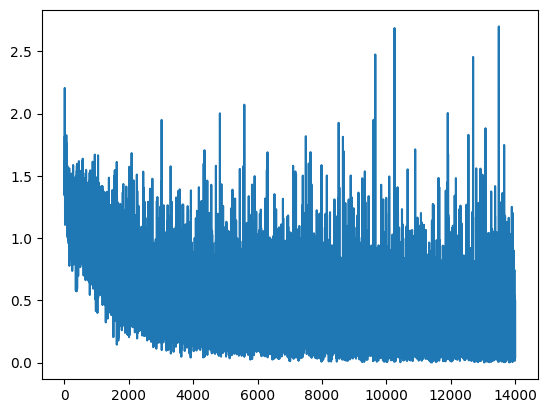

In [14]:
plt.plot(train_losses)

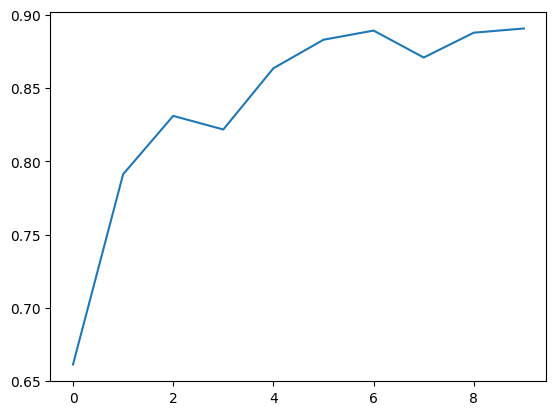

In [15]:
plt.plot(test_accuracy)

In [16]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [17]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 4988/5600 (0.8907)
{'acc_detail': tensor([0.7936, 0.9321, 0.8900, 0.9471], device='cuda:0'),
 'acc_unweighted': tensor(0.8907, device='cuda:0'),
 'acc_weighted': tensor(0.8907, device='cuda:0'),
 'f1s_detail': tensor([0.8452, 0.9252, 0.9305, 0.8633], device='cuda:0'),
 'f1s_unweighted': tensor(0.8911, device='cuda:0'),
 'f1s_weighted': tensor(0.8911, device='cuda:0'),
 'precision_detail': tensor([0.9040, 0.9184, 0.9750, 0.7931], device='cuda:0'),
 'recall_detail': tensor([0.7936, 0.9321, 0.8900, 0.9471], device='cuda:0'),
 'rocauc': tensor(0.9861, device='cuda:0'),
 'rocauc_detail': tensor([0.9753, 0.9922, 0.9942, 0.9825], device='cuda:0'),
 'uar': tensor(0.8907, device='cuda:0'),
 'wap': tensor(0.8976, device='cuda:0')}


tensor([[1111,   31,    9,  249],
        [  31, 1305,   19,   45],
        [  41,   61, 1246,   52],
        [  46,   24,    4, 1326]], device='cuda:0')

In [18]:
model_path = '../models_esd4/esd4_m13mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50

best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_esd4/esd4_m13mfcc128_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [26]:
checkpoint_path = f'../models_esd4/esd4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

In [ ]:
filtviz.visualize_filters(filter_domain='freq')

In [ ]:
filtviz.visualize_one_window(n_out=10)

In [ ]:
filtviz.visualize_one_window(n_out=50)

In [ ]:
filtviz.visualize_window_params()

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
start_epoch = 151
n_epoch = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
start_epoch = 201
n_epoch = 300

optimizer = optim.RAdam(model.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)